In [36]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct
import os
from tqdm import tqdm
from tqdm import trange
from tensorflow.python.client import device_lib


![lables_ubyte_structure](img/labels.png)

In [37]:
def load_mnist_train(path, kind='train'): 
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

![images_ubyte_structure](img/images.png)

In [38]:
def load_mnist_test(path, kind='t10k'): 
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind) 
    images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind) 
    with open(labels_path, 'rb') as lbpath: 
        magic, n = struct.unpack('>II',lbpath.read(8)) 
        labels = np.fromfile(lbpath,dtype=np.uint8) 
    with open(images_path, 'rb') as imgpath: 
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) 
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)
    
    return images, labels

In [39]:
def check_available_gpus():
    local_devices = device_lib.list_local_devices()
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    gpu_num = len(gpu_names)
    print('{0} GPUs are detected : {1}'.format(gpu_num, gpu_names))
    return gpu_num

In [40]:
check_available_gpus()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1 GPUs are detected : ['/device:GPU:0']


In [41]:
path = os.getcwd()
train_images, train_labels = load_mnist_train(path)
test_images, test_labels = load_mnist_test(path)
print(len(train_images))

60000


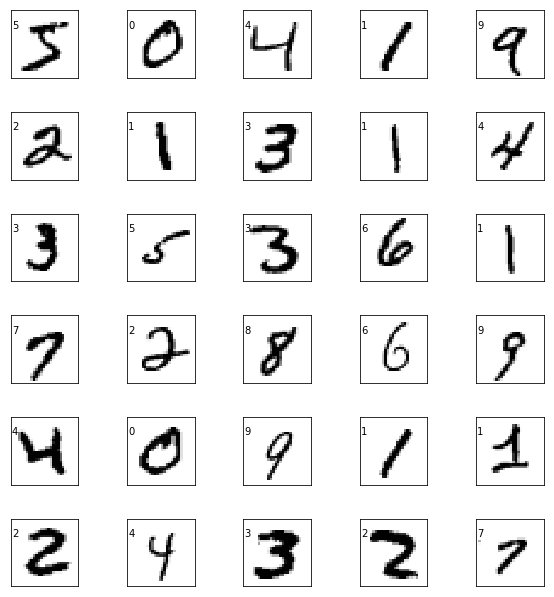

In [42]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
for i in range(30):
    image = np.reshape(train_images[i],[28,28])
    ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
    ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
    ax.text(0,7,str(train_labels[i]))
plt.show()

In [43]:
train_epochs = 35
batch_size = 5000
noise_factor = 0.5

Input_height = 28
Input_width = 28

input_x = tf.placeholder(tf.float32, shape=[None, Input_height * Input_width], name='input')
input_matrix = tf.reshape(input_x, shape=[-1, Input_height, Input_width, 1])


#encode_processing
#input 28*28
#output 14*14*32
kernal_1 = tf.Variable(tf.truncated_normal(shape=[3,3,1,32], stddev=0.1, name='kernal_1'))
bias_1 = tf.Variable(tf.constant(0.0, shape=[32], name='bias_1'))
conv1 = tf.nn.conv2d(input=input_matrix, filter=kernal_1, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.bias_add(conv1, bias_1, name='conv_1')
activ_1 = tf.nn.relu(conv1, name='activ_1')
pool1 = tf.nn.max_pool(value=activ_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name='max_pool_1')
#pool1 = tf.layers.batch_normalization(pool1)


#input 14*14*32
#output 7*7*32
kernal_2 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 32], stddev=0.1, name='kernal_2'))
bias_2 = tf.Variable(tf.constant(0.0, shape=[32], name='bias_2'))
conv2 = tf.nn.conv2d(input=pool1, filter=kernal_2, strides=[1, 1, 1, 1], padding='SAME')
conv2 = tf.nn.bias_add(conv2, bias_2, name='conv_2')
activ_2 = tf.nn.relu(conv2, name='activ_2')
pool2 = tf.nn.max_pool(value=activ_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_2')
#pool2 = tf.layers.batch_normalization(pool2)

#input 7*7*32
#output 4*4*16
kernal_3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 16], stddev=0.1, name='kernal_3'))
bias_3 = tf.Variable(tf.constant(0.0, shape=[16]))
conv3 = tf.nn.conv2d(input=pool2, filter=kernal_3, strides=[1, 1, 1, 1], padding='SAME')
conv3 = tf.nn.bias_add(conv3, bias_3)
activ_3 = tf.nn.relu(conv3, name='activ_3')
pool3 = tf.nn.max_pool(value=activ_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_3')
#pool3 = tf.layers.batch_normalization(pool3)

#input 4*4*16
#output 1*1*64
kernal_4 = tf.Variable(tf.truncated_normal(shape=[4, 4, 16, 64], stddev=0.1, name='kernal_4'))
bias_4 = tf.Variable(tf.constant(0.0, shape=[64]))
conv4 = tf.nn.conv2d(input=pool3, filter=kernal_4, strides=[1, 1, 1, 1], padding='SAME')
conv4 = tf.nn.bias_add(conv4, bias_4)
activ_4 = tf.nn.relu(conv4, name='activ_4')
pool4 = tf.nn.max_pool(value=activ_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='max_pool_4')


#decode_processing
deconv_weight_0 = tf.Variable(tf.truncated_normal(shape=[4, 4, 16, 64], stddev=0.1), name='deconv_weight_0')
deconv0 = tf.nn.conv2d_transpose(value=pool4, filter=deconv_weight_0, output_shape=[batch_size, 4, 4, 16], strides=[1, 2, 2, 1], padding='SAME', name='deconv_1')


#input 4*4*16
#output 7*7*32
deconv_weight_1 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 16], stddev=0.1), name='deconv_weight_1')
deconv1 = tf.nn.conv2d_transpose(value=pool3, filter=deconv_weight_1, output_shape=[batch_size, 7, 7, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_1')

 
## 2 deconv layer
## input 7*7*32
## output 14*14*32
deconv_weight_2 = tf.Variable(tf.truncated_normal(shape=[3, 3,32, 32], stddev=0.1), name='deconv_weight_2')
deconv2 = tf.nn.conv2d_transpose(value=deconv1, filter=deconv_weight_2, output_shape=[batch_size, 14, 14, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_2')
 

## 3 deconv layer
## input 14*14*32
## output 28*28*32
deconv_weight_3 = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 32], stddev=0.1, name='deconv_weight_3'))
deconv3 = tf.nn.conv2d_transpose(value=deconv2, filter=deconv_weight_3, output_shape=[batch_size, 28, 28, 32], strides=[1, 2, 2, 1], padding='SAME', name='deconv_3')


##CONV Layer
##input 28*28*32
##output 28*28*1
weight_final = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 1], stddev=0.1, name = 'weight_final'))
bias_final = tf.Variable(tf.constant(0.0, shape=[1], name='bias_final'))
conv_final = tf.nn.conv2d(input=deconv3, filter=weight_final, strides=[1, 1, 1, 1], padding='SAME')
conv_final = tf.nn.bias_add(conv_final, bias_final, name='conv_final')

output = tf.reshape(conv_final, shape=[-1,Input_height*Input_width])

loss = tf.reduce_mean(tf.pow(tf.subtract(output, input_x), 2.0),name='loss')
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
saver = tf.train.Saver()

In [44]:
if not os.path.exists('tmp/'):
    os.mkdir('tmp/')


In [58]:
#Training processing:
with tf.Session() as sess:
    if os.path.exists('tmp/checkpoint'):
        saver.restore(sess, 'tmp/model.ckpt')
    else:
        sess.run(tf.global_variables_initializer())
    total_batch  = int(len(train_images)/batch_size)
    min_lose = float('inf')
    for e in range(train_epochs):    
        for b in tqdm(range(total_batch)):
            batch = train_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            batch_cost, _=sess.run([loss, optimizer],feed_dict={input_x:batch})
            msg = "Global Step={:d}, Local batch={:d}, lose={:.4f}"
            if(batch_cost<min_lose):
                min_lose = batch_cost
                saver.save(sess, 'tmp/model.ckpt')
            print(msg.format(e,b,batch_cost))


INFO:tensorflow:Restoring parameters from tmp/model.ckpt


  8%|▊         | 1/12 [00:01<00:15,  1.38s/it]

Global Step=0, Local batch=0, lose=1513.1626


 17%|█▋        | 2/12 [00:02<00:12,  1.25s/it]

Global Step=0, Local batch=1, lose=1507.4563


 25%|██▌       | 3/12 [00:02<00:08,  1.04it/s]

Global Step=0, Local batch=2, lose=1526.6500


 33%|███▎      | 4/12 [00:02<00:06,  1.31it/s]

Global Step=0, Local batch=3, lose=1548.5234


 42%|████▏     | 5/12 [00:03<00:04,  1.60it/s]

Global Step=0, Local batch=4, lose=1528.2169


 50%|█████     | 6/12 [00:03<00:03,  1.90it/s]

Global Step=0, Local batch=5, lose=1521.9363


 58%|█████▊    | 7/12 [00:04<00:02,  1.69it/s]

Global Step=0, Local batch=6, lose=1505.3871


 67%|██████▋   | 8/12 [00:04<00:02,  1.99it/s]

Global Step=0, Local batch=7, lose=1508.5221


 75%|███████▌  | 9/12 [00:05<00:01,  1.73it/s]

Global Step=0, Local batch=8, lose=1498.5800


 83%|████████▎ | 10/12 [00:05<00:00,  2.03it/s]

Global Step=0, Local batch=9, lose=1517.0581


 92%|█████████▏| 11/12 [00:06<00:00,  1.74it/s]

Global Step=0, Local batch=10, lose=1486.6840


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=0, Local batch=11, lose=1488.5344


  8%|▊         | 1/12 [00:00<00:08,  1.34it/s]

Global Step=1, Local batch=0, lose=1473.7972


 17%|█▋        | 2/12 [00:01<00:07,  1.32it/s]

Global Step=1, Local batch=1, lose=1466.2709


 25%|██▌       | 3/12 [00:01<00:05,  1.62it/s]

Global Step=1, Local batch=2, lose=1475.7317


 33%|███▎      | 4/12 [00:02<00:04,  1.92it/s]

Global Step=1, Local batch=3, lose=1478.7740


 42%|████▏     | 5/12 [00:02<00:03,  2.19it/s]

Global Step=1, Local batch=4, lose=1487.8848


 50%|█████     | 6/12 [00:02<00:02,  2.45it/s]

Global Step=1, Local batch=5, lose=1476.0360


 58%|█████▊    | 7/12 [00:03<00:01,  2.67it/s]

Global Step=1, Local batch=6, lose=1475.9390


 67%|██████▋   | 8/12 [00:03<00:01,  2.86it/s]

Global Step=1, Local batch=7, lose=1483.5608


 75%|███████▌  | 9/12 [00:03<00:01,  2.99it/s]

Global Step=1, Local batch=8, lose=1485.7598


 83%|████████▎ | 10/12 [00:03<00:00,  3.10it/s]

Global Step=1, Local batch=9, lose=1520.5463


 92%|█████████▏| 11/12 [00:04<00:00,  3.17it/s]

Global Step=1, Local batch=10, lose=1473.7019


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=1, Local batch=11, lose=1478.8009


  8%|▊         | 1/12 [00:00<00:03,  3.36it/s]

Global Step=2, Local batch=0, lose=1466.7314


 17%|█▋        | 2/12 [00:01<00:04,  2.30it/s]

Global Step=2, Local batch=1, lose=1464.5582


 25%|██▌       | 3/12 [00:01<00:03,  2.54it/s]

Global Step=2, Local batch=2, lose=1482.8888


 33%|███▎      | 4/12 [00:01<00:02,  2.75it/s]

Global Step=2, Local batch=3, lose=1501.9368


 42%|████▏     | 5/12 [00:01<00:02,  2.90it/s]

Global Step=2, Local batch=4, lose=1518.3496


 50%|█████     | 6/12 [00:02<00:01,  3.02it/s]

Global Step=2, Local batch=5, lose=1529.1309


 58%|█████▊    | 7/12 [00:02<00:01,  3.12it/s]

Global Step=2, Local batch=6, lose=1515.1625


 67%|██████▋   | 8/12 [00:02<00:01,  3.21it/s]

Global Step=2, Local batch=7, lose=1499.3639


 75%|███████▌  | 9/12 [00:03<00:00,  3.25it/s]

Global Step=2, Local batch=8, lose=1533.4821


 83%|████████▎ | 10/12 [00:03<00:00,  3.29it/s]

Global Step=2, Local batch=9, lose=1572.0032


 92%|█████████▏| 11/12 [00:03<00:00,  3.30it/s]

Global Step=2, Local batch=10, lose=1482.8003


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=2, Local batch=11, lose=1510.7084


  8%|▊         | 1/12 [00:00<00:03,  3.41it/s]

Global Step=3, Local batch=0, lose=1482.8690


 17%|█▋        | 2/12 [00:00<00:02,  3.39it/s]

Global Step=3, Local batch=1, lose=1468.5669


 25%|██▌       | 3/12 [00:00<00:02,  3.38it/s]

Global Step=3, Local batch=2, lose=1479.1962


 33%|███▎      | 4/12 [00:01<00:02,  3.36it/s]

Global Step=3, Local batch=3, lose=1468.2493


 42%|████▏     | 5/12 [00:01<00:02,  3.35it/s]

Global Step=3, Local batch=4, lose=1488.2900


 50%|█████     | 6/12 [00:01<00:01,  3.34it/s]

Global Step=3, Local batch=5, lose=1468.7217


 58%|█████▊    | 7/12 [00:02<00:01,  3.35it/s]

Global Step=3, Local batch=6, lose=1479.0724


 67%|██████▋   | 8/12 [00:02<00:01,  3.31it/s]

Global Step=3, Local batch=7, lose=1482.0304


 75%|███████▌  | 9/12 [00:02<00:00,  3.34it/s]

Global Step=3, Local batch=8, lose=1467.1493


 83%|████████▎ | 10/12 [00:03<00:00,  3.31it/s]

Global Step=3, Local batch=9, lose=1503.3890


 92%|█████████▏| 11/12 [00:03<00:00,  3.27it/s]

Global Step=3, Local batch=10, lose=1466.2133


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=3, Local batch=11, lose=1481.4347


  8%|▊         | 1/12 [00:00<00:03,  3.07it/s]

Global Step=4, Local batch=0, lose=1473.4720


 17%|█▋        | 2/12 [00:01<00:04,  2.13it/s]

Global Step=4, Local batch=1, lose=1461.9883


 25%|██▌       | 3/12 [00:01<00:03,  2.36it/s]

Global Step=4, Local batch=2, lose=1468.3657


 33%|███▎      | 4/12 [00:01<00:03,  2.59it/s]

Global Step=4, Local batch=3, lose=1475.2904


 42%|████▏     | 5/12 [00:02<00:02,  2.79it/s]

Global Step=4, Local batch=4, lose=1465.4097


 50%|█████     | 6/12 [00:02<00:02,  2.10it/s]

Global Step=4, Local batch=5, lose=1459.9122


 58%|█████▊    | 7/12 [00:03<00:02,  2.37it/s]

Global Step=4, Local batch=6, lose=1465.8013


 67%|██████▋   | 8/12 [00:03<00:01,  2.60it/s]

Global Step=4, Local batch=7, lose=1470.5764


 75%|███████▌  | 9/12 [00:03<00:01,  2.78it/s]

Global Step=4, Local batch=8, lose=1465.7263


 83%|████████▎ | 10/12 [00:03<00:00,  2.95it/s]

Global Step=4, Local batch=9, lose=1487.9651


 92%|█████████▏| 11/12 [00:04<00:00,  2.14it/s]

Global Step=4, Local batch=10, lose=1450.3237


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=4, Local batch=11, lose=1465.8604


  8%|▊         | 1/12 [00:00<00:03,  3.39it/s]

Global Step=5, Local batch=0, lose=1452.8048


 17%|█▋        | 2/12 [00:01<00:04,  2.32it/s]

Global Step=5, Local batch=1, lose=1442.6108


 25%|██▌       | 3/12 [00:01<00:03,  2.57it/s]

Global Step=5, Local batch=2, lose=1447.1431


 33%|███▎      | 4/12 [00:01<00:02,  2.76it/s]

Global Step=5, Local batch=3, lose=1442.7354


 42%|████▏     | 5/12 [00:02<00:03,  2.10it/s]

Global Step=5, Local batch=4, lose=1440.4613


 50%|█████     | 6/12 [00:03<00:03,  1.80it/s]

Global Step=5, Local batch=5, lose=1439.3748


 58%|█████▊    | 7/12 [00:03<00:02,  2.09it/s]

Global Step=5, Local batch=6, lose=1449.4576


 67%|██████▋   | 8/12 [00:03<00:01,  2.36it/s]

Global Step=5, Local batch=7, lose=1452.0354


 75%|███████▌  | 9/12 [00:04<00:01,  2.58it/s]

Global Step=5, Local batch=8, lose=1447.1324


 83%|████████▎ | 10/12 [00:04<00:00,  2.78it/s]

Global Step=5, Local batch=9, lose=1475.5918


 92%|█████████▏| 11/12 [00:04<00:00,  2.93it/s]

Global Step=5, Local batch=10, lose=1450.3221


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=5, Local batch=11, lose=1486.5751


  8%|▊         | 1/12 [00:00<00:03,  3.39it/s]

Global Step=6, Local batch=0, lose=1494.1716


 17%|█▋        | 2/12 [00:00<00:02,  3.38it/s]

Global Step=6, Local batch=1, lose=1549.3202


 25%|██▌       | 3/12 [00:00<00:02,  3.39it/s]

Global Step=6, Local batch=2, lose=1520.9039


 33%|███▎      | 4/12 [00:01<00:02,  3.39it/s]

Global Step=6, Local batch=3, lose=1529.1344


 42%|████▏     | 5/12 [00:01<00:02,  3.38it/s]

Global Step=6, Local batch=4, lose=1539.4313


 50%|█████     | 6/12 [00:01<00:01,  3.36it/s]

Global Step=6, Local batch=5, lose=1497.3311


 58%|█████▊    | 7/12 [00:02<00:01,  3.37it/s]

Global Step=6, Local batch=6, lose=1501.9878


 67%|██████▋   | 8/12 [00:02<00:01,  3.37it/s]

Global Step=6, Local batch=7, lose=1485.9462


 75%|███████▌  | 9/12 [00:02<00:00,  3.37it/s]

Global Step=6, Local batch=8, lose=1518.7327


 83%|████████▎ | 10/12 [00:02<00:00,  3.37it/s]

Global Step=6, Local batch=9, lose=1542.1279


 92%|█████████▏| 11/12 [00:03<00:00,  3.36it/s]

Global Step=6, Local batch=10, lose=1484.0437


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=6, Local batch=11, lose=1468.4310


  8%|▊         | 1/12 [00:00<00:03,  3.36it/s]

Global Step=7, Local batch=0, lose=1466.4934


 17%|█▋        | 2/12 [00:00<00:02,  3.36it/s]

Global Step=7, Local batch=1, lose=1444.3712


 25%|██▌       | 3/12 [00:00<00:02,  3.35it/s]

Global Step=7, Local batch=2, lose=1442.5466


 33%|███▎      | 4/12 [00:01<00:02,  3.36it/s]

Global Step=7, Local batch=3, lose=1465.9783


 42%|████▏     | 5/12 [00:01<00:03,  2.31it/s]

Global Step=7, Local batch=4, lose=1436.4789


 50%|█████     | 6/12 [00:02<00:03,  1.90it/s]

Global Step=7, Local batch=5, lose=1433.8268


 58%|█████▊    | 7/12 [00:02<00:02,  2.18it/s]

Global Step=7, Local batch=6, lose=1444.0745


 67%|██████▋   | 8/12 [00:03<00:01,  2.44it/s]

Global Step=7, Local batch=7, lose=1444.1564


 75%|███████▌  | 9/12 [00:03<00:01,  2.65it/s]

Global Step=7, Local batch=8, lose=1447.6342


 83%|████████▎ | 10/12 [00:03<00:00,  2.84it/s]

Global Step=7, Local batch=9, lose=1471.2428


 92%|█████████▏| 11/12 [00:04<00:00,  2.98it/s]

Global Step=7, Local batch=10, lose=1437.3461


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=7, Local batch=11, lose=1435.5349


  8%|▊         | 1/12 [00:00<00:08,  1.32it/s]

Global Step=8, Local batch=0, lose=1419.9755


 17%|█▋        | 2/12 [00:01<00:07,  1.32it/s]

Global Step=8, Local batch=1, lose=1418.8245


 25%|██▌       | 3/12 [00:01<00:05,  1.62it/s]

Global Step=8, Local batch=2, lose=1418.9673


 33%|███▎      | 4/12 [00:02<00:04,  1.92it/s]

Global Step=8, Local batch=3, lose=1426.0217


 42%|████▏     | 5/12 [00:02<00:03,  2.20it/s]

Global Step=8, Local batch=4, lose=1438.6101


 50%|█████     | 6/12 [00:02<00:02,  2.46it/s]

Global Step=8, Local batch=5, lose=1419.5760


 58%|█████▊    | 7/12 [00:02<00:01,  2.67it/s]

Global Step=8, Local batch=6, lose=1418.8651


 67%|██████▋   | 8/12 [00:03<00:01,  2.84it/s]

Global Step=8, Local batch=7, lose=1434.7715


 75%|███████▌  | 9/12 [00:03<00:01,  2.99it/s]

Global Step=8, Local batch=8, lose=1446.3445


 83%|████████▎ | 10/12 [00:03<00:00,  3.08it/s]

Global Step=8, Local batch=9, lose=1488.5209


 92%|█████████▏| 11/12 [00:04<00:00,  3.17it/s]

Global Step=8, Local batch=10, lose=1445.5491


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=8, Local batch=11, lose=1446.2148


  8%|▊         | 1/12 [00:00<00:03,  3.34it/s]

Global Step=9, Local batch=0, lose=1438.8309


 17%|█▋        | 2/12 [00:00<00:03,  3.33it/s]

Global Step=9, Local batch=1, lose=1435.1075


 25%|██▌       | 3/12 [00:00<00:02,  3.34it/s]

Global Step=9, Local batch=2, lose=1448.0498


 33%|███▎      | 4/12 [00:01<00:02,  3.34it/s]

Global Step=9, Local batch=3, lose=1455.2426


 42%|████▏     | 5/12 [00:01<00:02,  3.33it/s]

Global Step=9, Local batch=4, lose=1432.1870


 50%|█████     | 6/12 [00:02<00:02,  2.23it/s]

Global Step=9, Local batch=5, lose=1408.9412


 58%|█████▊    | 7/12 [00:02<00:02,  2.48it/s]

Global Step=9, Local batch=6, lose=1439.1475


 67%|██████▋   | 8/12 [00:02<00:01,  2.68it/s]

Global Step=9, Local batch=7, lose=1440.8754


 75%|███████▌  | 9/12 [00:03<00:01,  2.85it/s]

Global Step=9, Local batch=8, lose=1422.6230


 83%|████████▎ | 10/12 [00:03<00:00,  2.98it/s]

Global Step=9, Local batch=9, lose=1455.8474


 92%|█████████▏| 11/12 [00:03<00:00,  3.09it/s]

Global Step=9, Local batch=10, lose=1419.0836


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=9, Local batch=11, lose=1424.1356


  8%|▊         | 1/12 [00:00<00:03,  3.33it/s]

Global Step=10, Local batch=0, lose=1416.4108


 17%|█▋        | 2/12 [00:00<00:03,  3.32it/s]

Global Step=10, Local batch=1, lose=1413.9969


 25%|██▌       | 3/12 [00:00<00:02,  3.34it/s]

Global Step=10, Local batch=2, lose=1428.7029


 33%|███▎      | 4/12 [00:01<00:02,  3.35it/s]

Global Step=10, Local batch=3, lose=1455.0526


 42%|████▏     | 5/12 [00:01<00:02,  3.36it/s]

Global Step=10, Local batch=4, lose=1457.6459


 50%|█████     | 6/12 [00:01<00:01,  3.36it/s]

Global Step=10, Local batch=5, lose=1458.9037


 58%|█████▊    | 7/12 [00:02<00:01,  3.36it/s]

Global Step=10, Local batch=6, lose=1438.1943


 67%|██████▋   | 8/12 [00:02<00:01,  3.36it/s]

Global Step=10, Local batch=7, lose=1415.0529


 75%|███████▌  | 9/12 [00:02<00:00,  3.36it/s]

Global Step=10, Local batch=8, lose=1449.2633


 83%|████████▎ | 10/12 [00:02<00:00,  3.34it/s]

Global Step=10, Local batch=9, lose=1482.2665


 92%|█████████▏| 11/12 [00:03<00:00,  2.24it/s]

Global Step=10, Local batch=10, lose=1406.1049


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=10, Local batch=11, lose=1430.9207


  8%|▊         | 1/12 [00:00<00:03,  3.12it/s]

Global Step=11, Local batch=0, lose=1417.4015


 17%|█▋        | 2/12 [00:01<00:04,  2.13it/s]

Global Step=11, Local batch=1, lose=1390.1251


 25%|██▌       | 3/12 [00:01<00:03,  2.40it/s]

Global Step=11, Local batch=2, lose=1418.1571


 33%|███▎      | 4/12 [00:01<00:03,  2.62it/s]

Global Step=11, Local batch=3, lose=1424.5231


 42%|████▏     | 5/12 [00:02<00:02,  2.80it/s]

Global Step=11, Local batch=4, lose=1411.2052


 50%|█████     | 6/12 [00:02<00:02,  2.95it/s]

Global Step=11, Local batch=5, lose=1423.1342


 58%|█████▊    | 7/12 [00:02<00:01,  3.06it/s]

Global Step=11, Local batch=6, lose=1422.7446


 67%|██████▋   | 8/12 [00:02<00:01,  3.11it/s]

Global Step=11, Local batch=7, lose=1441.8363


 75%|███████▌  | 9/12 [00:03<00:00,  3.12it/s]

Global Step=11, Local batch=8, lose=1461.4677


 83%|████████▎ | 10/12 [00:03<00:00,  3.16it/s]

Global Step=11, Local batch=9, lose=1479.3401


 92%|█████████▏| 11/12 [00:03<00:00,  3.14it/s]

Global Step=11, Local batch=10, lose=1426.6376


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=11, Local batch=11, lose=1440.1448


  8%|▊         | 1/12 [00:00<00:03,  3.11it/s]

Global Step=12, Local batch=0, lose=1398.5631


 17%|█▋        | 2/12 [00:00<00:03,  3.10it/s]

Global Step=12, Local batch=1, lose=1393.4661


 25%|██▌       | 3/12 [00:00<00:02,  3.16it/s]

Global Step=12, Local batch=2, lose=1407.0034


 33%|███▎      | 4/12 [00:01<00:02,  3.20it/s]

Global Step=12, Local batch=3, lose=1416.4329


 42%|████▏     | 5/12 [00:01<00:02,  3.23it/s]

Global Step=12, Local batch=4, lose=1445.6359


 50%|█████     | 6/12 [00:01<00:01,  3.25it/s]

Global Step=12, Local batch=5, lose=1429.1154


 58%|█████▊    | 7/12 [00:02<00:01,  3.22it/s]

Global Step=12, Local batch=6, lose=1425.3398


 67%|██████▋   | 8/12 [00:02<00:01,  3.24it/s]

Global Step=12, Local batch=7, lose=1409.4153


 75%|███████▌  | 9/12 [00:02<00:00,  3.26it/s]

Global Step=12, Local batch=8, lose=1418.3922


 83%|████████▎ | 10/12 [00:03<00:00,  3.28it/s]

Global Step=12, Local batch=9, lose=1482.8347


 92%|█████████▏| 11/12 [00:03<00:00,  3.30it/s]

Global Step=12, Local batch=10, lose=1421.7113


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=12, Local batch=11, lose=1414.7908


  8%|▊         | 1/12 [00:00<00:03,  3.36it/s]

Global Step=13, Local batch=0, lose=1401.7784


 17%|█▋        | 2/12 [00:01<00:04,  2.25it/s]

Global Step=13, Local batch=1, lose=1388.4832


 25%|██▌       | 3/12 [00:01<00:03,  2.48it/s]

Global Step=13, Local batch=2, lose=1399.5571


 33%|███▎      | 4/12 [00:01<00:03,  2.65it/s]

Global Step=13, Local batch=3, lose=1417.5247


 42%|████▏     | 5/12 [00:02<00:02,  2.81it/s]

Global Step=13, Local batch=4, lose=1419.8406


 50%|█████     | 6/12 [00:02<00:02,  2.94it/s]

Global Step=13, Local batch=5, lose=1401.9103


 58%|█████▊    | 7/12 [00:02<00:01,  3.04it/s]

Global Step=13, Local batch=6, lose=1408.6151


 67%|██████▋   | 8/12 [00:02<00:01,  3.12it/s]

Global Step=13, Local batch=7, lose=1421.6599


 75%|███████▌  | 9/12 [00:03<00:00,  3.18it/s]

Global Step=13, Local batch=8, lose=1421.8018


 83%|████████▎ | 10/12 [00:03<00:00,  3.20it/s]

Global Step=13, Local batch=9, lose=1464.8920


 92%|█████████▏| 11/12 [00:03<00:00,  3.23it/s]

Global Step=13, Local batch=10, lose=1412.7910


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=13, Local batch=11, lose=1394.3674


  8%|▊         | 1/12 [00:00<00:03,  2.99it/s]

Global Step=14, Local batch=0, lose=1391.7607


 17%|█▋        | 2/12 [00:00<00:03,  3.01it/s]

Global Step=14, Local batch=1, lose=1397.0243


 25%|██▌       | 3/12 [00:00<00:02,  3.02it/s]

Global Step=14, Local batch=2, lose=1403.1436


 33%|███▎      | 4/12 [00:01<00:02,  3.03it/s]

Global Step=14, Local batch=3, lose=1406.1797


 42%|████▏     | 5/12 [00:01<00:02,  3.04it/s]

Global Step=14, Local batch=4, lose=1414.2294


 50%|█████     | 6/12 [00:01<00:01,  3.04it/s]

Global Step=14, Local batch=5, lose=1416.0632


 58%|█████▊    | 7/12 [00:02<00:01,  3.01it/s]

Global Step=14, Local batch=6, lose=1405.6594


 67%|██████▋   | 8/12 [00:02<00:01,  3.01it/s]

Global Step=14, Local batch=7, lose=1413.1254


 75%|███████▌  | 9/12 [00:02<00:00,  3.00it/s]

Global Step=14, Local batch=8, lose=1398.9189


 83%|████████▎ | 10/12 [00:03<00:00,  3.07it/s]

Global Step=14, Local batch=9, lose=1423.6785


 92%|█████████▏| 11/12 [00:03<00:00,  3.13it/s]

Global Step=14, Local batch=10, lose=1390.6569


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=14, Local batch=11, lose=1383.9893


  8%|▊         | 1/12 [00:00<00:08,  1.28it/s]

Global Step=15, Local batch=0, lose=1368.6786


 17%|█▋        | 2/12 [00:01<00:07,  1.28it/s]

Global Step=15, Local batch=1, lose=1363.0115


 25%|██▌       | 3/12 [00:01<00:05,  1.58it/s]

Global Step=15, Local batch=2, lose=1371.6416


 33%|███▎      | 4/12 [00:02<00:04,  1.87it/s]

Global Step=15, Local batch=3, lose=1376.2006


 42%|████▏     | 5/12 [00:02<00:03,  2.16it/s]

Global Step=15, Local batch=4, lose=1375.2294


 50%|█████     | 6/12 [00:02<00:02,  2.42it/s]

Global Step=15, Local batch=5, lose=1373.6410


 58%|█████▊    | 7/12 [00:03<00:01,  2.63it/s]

Global Step=15, Local batch=6, lose=1380.9662


 67%|██████▋   | 8/12 [00:03<00:01,  2.81it/s]

Global Step=15, Local batch=7, lose=1384.3281


 75%|███████▌  | 9/12 [00:03<00:01,  2.95it/s]

Global Step=15, Local batch=8, lose=1389.0791


 83%|████████▎ | 10/12 [00:03<00:00,  3.04it/s]

Global Step=15, Local batch=9, lose=1439.7667


 92%|█████████▏| 11/12 [00:04<00:00,  3.12it/s]

Global Step=15, Local batch=10, lose=1450.8889


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=15, Local batch=11, lose=1560.0920


  8%|▊         | 1/12 [00:00<00:03,  3.34it/s]

Global Step=16, Local batch=0, lose=1551.8481


 17%|█▋        | 2/12 [00:00<00:03,  3.33it/s]

Global Step=16, Local batch=1, lose=1467.6897


 25%|██▌       | 3/12 [00:00<00:02,  3.33it/s]

Global Step=16, Local batch=2, lose=1481.4988


 33%|███▎      | 4/12 [00:01<00:02,  3.32it/s]

Global Step=16, Local batch=3, lose=1494.5347


 42%|████▏     | 5/12 [00:01<00:02,  3.32it/s]

Global Step=16, Local batch=4, lose=1442.4688


 50%|█████     | 6/12 [00:01<00:01,  3.32it/s]

Global Step=16, Local batch=5, lose=1456.9200


 58%|█████▊    | 7/12 [00:02<00:01,  3.32it/s]

Global Step=16, Local batch=6, lose=1461.4385


 67%|██████▋   | 8/12 [00:02<00:01,  3.32it/s]

Global Step=16, Local batch=7, lose=1434.7098


 75%|███████▌  | 9/12 [00:02<00:00,  3.32it/s]

Global Step=16, Local batch=8, lose=1471.0518


 83%|████████▎ | 10/12 [00:03<00:00,  3.32it/s]

Global Step=16, Local batch=9, lose=1465.2987


 92%|█████████▏| 11/12 [00:03<00:00,  3.32it/s]

Global Step=16, Local batch=10, lose=1456.6594


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=16, Local batch=11, lose=1413.0940


  8%|▊         | 1/12 [00:00<00:03,  3.31it/s]

Global Step=17, Local batch=0, lose=1430.4641


 17%|█▋        | 2/12 [00:00<00:03,  3.31it/s]

Global Step=17, Local batch=1, lose=1389.1683


 25%|██▌       | 3/12 [00:00<00:02,  3.31it/s]

Global Step=17, Local batch=2, lose=1416.3644


 33%|███▎      | 4/12 [00:01<00:02,  3.32it/s]

Global Step=17, Local batch=3, lose=1396.3706


 42%|████▏     | 5/12 [00:01<00:02,  3.33it/s]

Global Step=17, Local batch=4, lose=1403.9156


 50%|█████     | 6/12 [00:01<00:01,  3.32it/s]

Global Step=17, Local batch=5, lose=1384.9897


 58%|█████▊    | 7/12 [00:02<00:01,  3.32it/s]

Global Step=17, Local batch=6, lose=1395.4946


 67%|██████▋   | 8/12 [00:02<00:01,  3.31it/s]

Global Step=17, Local batch=7, lose=1396.2346


 75%|███████▌  | 9/12 [00:02<00:00,  3.32it/s]

Global Step=17, Local batch=8, lose=1392.5410


 83%|████████▎ | 10/12 [00:03<00:00,  3.33it/s]

Global Step=17, Local batch=9, lose=1421.0432


 92%|█████████▏| 11/12 [00:03<00:00,  3.31it/s]

Global Step=17, Local batch=10, lose=1379.4318


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=17, Local batch=11, lose=1390.1990


  8%|▊         | 1/12 [00:00<00:03,  3.33it/s]

Global Step=18, Local batch=0, lose=1382.6547


 17%|█▋        | 2/12 [00:00<00:03,  3.33it/s]

Global Step=18, Local batch=1, lose=1377.4994


 25%|██▌       | 3/12 [00:00<00:02,  3.34it/s]

Global Step=18, Local batch=2, lose=1393.4323


 33%|███▎      | 4/12 [00:01<00:02,  3.33it/s]

Global Step=18, Local batch=3, lose=1411.7936


 42%|████▏     | 5/12 [00:01<00:02,  3.32it/s]

Global Step=18, Local batch=4, lose=1402.7323


 50%|█████     | 6/12 [00:01<00:01,  3.32it/s]

Global Step=18, Local batch=5, lose=1385.8900


 58%|█████▊    | 7/12 [00:02<00:01,  3.32it/s]

Global Step=18, Local batch=6, lose=1377.8479


 67%|██████▋   | 8/12 [00:02<00:01,  3.33it/s]

Global Step=18, Local batch=7, lose=1376.2701


 75%|███████▌  | 9/12 [00:02<00:00,  3.32it/s]

Global Step=18, Local batch=8, lose=1374.4978


 83%|████████▎ | 10/12 [00:03<00:00,  3.31it/s]

Global Step=18, Local batch=9, lose=1406.4019


 92%|█████████▏| 11/12 [00:03<00:00,  3.31it/s]

Global Step=18, Local batch=10, lose=1366.9805


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=18, Local batch=11, lose=1368.6896


  8%|▊         | 1/12 [00:00<00:08,  1.33it/s]

Global Step=19, Local batch=0, lose=1362.2482


 17%|█▋        | 2/12 [00:01<00:07,  1.29it/s]

Global Step=19, Local batch=1, lose=1347.5264


 25%|██▌       | 3/12 [00:01<00:05,  1.58it/s]

Global Step=19, Local batch=2, lose=1351.0563


 33%|███▎      | 4/12 [00:02<00:04,  1.85it/s]

Global Step=19, Local batch=3, lose=1367.2908


 42%|████▏     | 5/12 [00:02<00:03,  2.14it/s]

Global Step=19, Local batch=4, lose=1371.0902


 50%|█████     | 6/12 [00:02<00:02,  2.39it/s]

Global Step=19, Local batch=5, lose=1363.9640


 58%|█████▊    | 7/12 [00:03<00:01,  2.61it/s]

Global Step=19, Local batch=6, lose=1371.7751


 67%|██████▋   | 8/12 [00:03<00:01,  2.79it/s]

Global Step=19, Local batch=7, lose=1379.2191


 75%|███████▌  | 9/12 [00:03<00:01,  2.93it/s]

Global Step=19, Local batch=8, lose=1383.4001


 83%|████████▎ | 10/12 [00:04<00:00,  3.05it/s]

Global Step=19, Local batch=9, lose=1424.2054


 92%|█████████▏| 11/12 [00:04<00:00,  3.12it/s]

Global Step=19, Local batch=10, lose=1399.6366


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=19, Local batch=11, lose=1397.0548


  8%|▊         | 1/12 [00:00<00:03,  3.34it/s]

Global Step=20, Local batch=0, lose=1376.2618


 17%|█▋        | 2/12 [00:00<00:02,  3.34it/s]

Global Step=20, Local batch=1, lose=1352.3390


 25%|██▌       | 3/12 [00:00<00:02,  3.33it/s]

Global Step=20, Local batch=2, lose=1359.0612


 33%|███▎      | 4/12 [00:01<00:02,  3.32it/s]

Global Step=20, Local batch=3, lose=1379.8102


 42%|████▏     | 5/12 [00:01<00:02,  3.31it/s]

Global Step=20, Local batch=4, lose=1379.2872


 50%|█████     | 6/12 [00:01<00:01,  3.29it/s]

Global Step=20, Local batch=5, lose=1353.9115


 58%|█████▊    | 7/12 [00:02<00:01,  3.28it/s]

Global Step=20, Local batch=6, lose=1366.1699


 67%|██████▋   | 8/12 [00:02<00:01,  3.29it/s]

Global Step=20, Local batch=7, lose=1399.3306


 75%|███████▌  | 9/12 [00:02<00:00,  3.29it/s]

Global Step=20, Local batch=8, lose=1400.4105


 83%|████████▎ | 10/12 [00:03<00:00,  3.30it/s]

Global Step=20, Local batch=9, lose=1463.9231


 92%|█████████▏| 11/12 [00:03<00:00,  3.31it/s]

Global Step=20, Local batch=10, lose=1442.9491


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=20, Local batch=11, lose=1465.9581


  8%|▊         | 1/12 [00:00<00:03,  3.34it/s]

Global Step=21, Local batch=0, lose=1409.8766


 17%|█▋        | 2/12 [00:00<00:03,  3.33it/s]

Global Step=21, Local batch=1, lose=1378.8755


 25%|██▌       | 3/12 [00:00<00:02,  3.32it/s]

Global Step=21, Local batch=2, lose=1377.7002


 33%|███▎      | 4/12 [00:01<00:02,  3.30it/s]

Global Step=21, Local batch=3, lose=1418.2699


 42%|████▏     | 5/12 [00:01<00:02,  3.30it/s]

Global Step=21, Local batch=4, lose=1429.5280


 50%|█████     | 6/12 [00:01<00:01,  3.31it/s]

Global Step=21, Local batch=5, lose=1371.6768


 58%|█████▊    | 7/12 [00:02<00:01,  3.31it/s]

Global Step=21, Local batch=6, lose=1376.2205


 67%|██████▋   | 8/12 [00:02<00:01,  3.31it/s]

Global Step=21, Local batch=7, lose=1390.8273


 75%|███████▌  | 9/12 [00:02<00:00,  3.30it/s]

Global Step=21, Local batch=8, lose=1422.4235


 83%|████████▎ | 10/12 [00:03<00:00,  3.21it/s]

Global Step=21, Local batch=9, lose=1465.3898


 92%|█████████▏| 11/12 [00:03<00:00,  3.22it/s]

Global Step=21, Local batch=10, lose=1362.6375


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=21, Local batch=11, lose=1381.1866


  8%|▊         | 1/12 [00:00<00:03,  3.02it/s]

Global Step=22, Local batch=0, lose=1375.3599


 17%|█▋        | 2/12 [00:00<00:03,  3.06it/s]

Global Step=22, Local batch=1, lose=1367.3282


 25%|██▌       | 3/12 [00:00<00:02,  3.10it/s]

Global Step=22, Local batch=2, lose=1373.9191


 33%|███▎      | 4/12 [00:01<00:02,  3.09it/s]

Global Step=22, Local batch=3, lose=1351.1450


 42%|████▏     | 5/12 [00:01<00:02,  3.14it/s]

Global Step=22, Local batch=4, lose=1370.2556


 50%|█████     | 6/12 [00:01<00:01,  3.18it/s]

Global Step=22, Local batch=5, lose=1363.2527


 58%|█████▊    | 7/12 [00:02<00:01,  3.23it/s]

Global Step=22, Local batch=6, lose=1367.9657


 67%|██████▋   | 8/12 [00:02<00:01,  3.26it/s]

Global Step=22, Local batch=7, lose=1390.7507


 75%|███████▌  | 9/12 [00:02<00:00,  3.27it/s]

Global Step=22, Local batch=8, lose=1365.5728


 83%|████████▎ | 10/12 [00:03<00:00,  3.29it/s]

Global Step=22, Local batch=9, lose=1394.6307


 92%|█████████▏| 11/12 [00:03<00:00,  3.29it/s]

Global Step=22, Local batch=10, lose=1357.3076


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=22, Local batch=11, lose=1351.1494


  8%|▊         | 1/12 [00:00<00:09,  1.12it/s]

Global Step=23, Local batch=0, lose=1345.3297


 17%|█▋        | 2/12 [00:01<00:08,  1.14it/s]

Global Step=23, Local batch=1, lose=1334.6287


 25%|██▌       | 3/12 [00:02<00:06,  1.42it/s]

Global Step=23, Local batch=2, lose=1341.8693


 33%|███▎      | 4/12 [00:02<00:04,  1.72it/s]

Global Step=23, Local batch=3, lose=1354.5223


 42%|████▏     | 5/12 [00:02<00:03,  2.01it/s]

Global Step=23, Local batch=4, lose=1354.8392


 50%|█████     | 6/12 [00:02<00:02,  2.25it/s]

Global Step=23, Local batch=5, lose=1359.0034


 58%|█████▊    | 7/12 [00:03<00:02,  2.45it/s]

Global Step=23, Local batch=6, lose=1370.7622


 67%|██████▋   | 8/12 [00:03<00:01,  2.66it/s]

Global Step=23, Local batch=7, lose=1377.1360


 75%|███████▌  | 9/12 [00:03<00:01,  2.83it/s]

Global Step=23, Local batch=8, lose=1384.0574


 83%|████████▎ | 10/12 [00:04<00:00,  2.89it/s]

Global Step=23, Local batch=9, lose=1432.3403


 92%|█████████▏| 11/12 [00:04<00:00,  2.95it/s]

Global Step=23, Local batch=10, lose=1392.3861


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=23, Local batch=11, lose=1387.4545


  8%|▊         | 1/12 [00:00<00:03,  3.04it/s]

Global Step=24, Local batch=0, lose=1347.1985


 17%|█▋        | 2/12 [00:00<00:03,  3.03it/s]

Global Step=24, Local batch=1, lose=1344.4347


 25%|██▌       | 3/12 [00:00<00:02,  3.12it/s]

Global Step=24, Local batch=2, lose=1360.6256


 33%|███▎      | 4/12 [00:01<00:02,  3.18it/s]

Global Step=24, Local batch=3, lose=1362.0885


 42%|████▏     | 5/12 [00:01<00:02,  3.22it/s]

Global Step=24, Local batch=4, lose=1359.8229


 50%|█████     | 6/12 [00:01<00:01,  3.21it/s]

Global Step=24, Local batch=5, lose=1341.7885


 58%|█████▊    | 7/12 [00:02<00:01,  3.12it/s]

Global Step=24, Local batch=6, lose=1351.9620


 67%|██████▋   | 8/12 [00:02<00:01,  3.13it/s]

Global Step=24, Local batch=7, lose=1369.8761


 75%|███████▌  | 9/12 [00:02<00:00,  3.18it/s]

Global Step=24, Local batch=8, lose=1356.4667


 83%|████████▎ | 10/12 [00:03<00:00,  3.21it/s]

Global Step=24, Local batch=9, lose=1376.2587


 92%|█████████▏| 11/12 [00:03<00:00,  3.23it/s]

Global Step=24, Local batch=10, lose=1339.5527


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=24, Local batch=11, lose=1346.7668


  8%|▊         | 1/12 [00:00<00:03,  3.08it/s]

Global Step=25, Local batch=0, lose=1345.5531


 17%|█▋        | 2/12 [00:00<00:03,  3.14it/s]

Global Step=25, Local batch=1, lose=1337.0796


 25%|██▌       | 3/12 [00:00<00:02,  3.17it/s]

Global Step=25, Local batch=2, lose=1343.4235


 33%|███▎      | 4/12 [00:01<00:02,  3.21it/s]

Global Step=25, Local batch=3, lose=1367.7279


 42%|████▏     | 5/12 [00:01<00:02,  3.23it/s]

Global Step=25, Local batch=4, lose=1375.7450


 50%|█████     | 6/12 [00:01<00:01,  3.25it/s]

Global Step=25, Local batch=5, lose=1378.7639


 58%|█████▊    | 7/12 [00:02<00:01,  3.27it/s]

Global Step=25, Local batch=6, lose=1380.6093


 67%|██████▋   | 8/12 [00:02<00:01,  3.26it/s]

Global Step=25, Local batch=7, lose=1366.1921


 75%|███████▌  | 9/12 [00:02<00:00,  3.25it/s]

Global Step=25, Local batch=8, lose=1360.4152


 83%|████████▎ | 10/12 [00:03<00:00,  3.26it/s]

Global Step=25, Local batch=9, lose=1410.4235


 92%|█████████▏| 11/12 [00:03<00:00,  3.27it/s]

Global Step=25, Local batch=10, lose=1367.0479


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=25, Local batch=11, lose=1361.9507


  8%|▊         | 1/12 [00:00<00:03,  3.26it/s]

Global Step=26, Local batch=0, lose=1346.2750


 17%|█▋        | 2/12 [00:00<00:03,  3.26it/s]

Global Step=26, Local batch=1, lose=1338.7980


 25%|██▌       | 3/12 [00:00<00:02,  3.27it/s]

Global Step=26, Local batch=2, lose=1352.3330


 33%|███▎      | 4/12 [00:01<00:02,  3.28it/s]

Global Step=26, Local batch=3, lose=1369.1940


 42%|████▏     | 5/12 [00:01<00:02,  3.28it/s]

Global Step=26, Local batch=4, lose=1374.1259


 50%|█████     | 6/12 [00:01<00:01,  3.29it/s]

Global Step=26, Local batch=5, lose=1373.5056


 58%|█████▊    | 7/12 [00:02<00:01,  3.28it/s]

Global Step=26, Local batch=6, lose=1372.9097


 67%|██████▋   | 8/12 [00:02<00:01,  3.27it/s]

Global Step=26, Local batch=7, lose=1352.8221


 75%|███████▌  | 9/12 [00:02<00:00,  3.28it/s]

Global Step=26, Local batch=8, lose=1363.9286


 83%|████████▎ | 10/12 [00:03<00:00,  3.28it/s]

Global Step=26, Local batch=9, lose=1390.7845


 92%|█████████▏| 11/12 [00:03<00:00,  3.27it/s]

Global Step=26, Local batch=10, lose=1346.5457


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=26, Local batch=11, lose=1365.0353


  8%|▊         | 1/12 [00:00<00:03,  3.26it/s]

Global Step=27, Local batch=0, lose=1335.2291


 17%|█▋        | 2/12 [00:00<00:03,  3.27it/s]

Global Step=27, Local batch=1, lose=1344.0186


 25%|██▌       | 3/12 [00:00<00:02,  3.26it/s]

Global Step=27, Local batch=2, lose=1349.4434


 33%|███▎      | 4/12 [00:01<00:02,  3.26it/s]

Global Step=27, Local batch=3, lose=1349.4456


 42%|████▏     | 5/12 [00:01<00:02,  3.25it/s]

Global Step=27, Local batch=4, lose=1350.4569


 50%|█████     | 6/12 [00:01<00:01,  3.26it/s]

Global Step=27, Local batch=5, lose=1335.9110


 58%|█████▊    | 7/12 [00:02<00:01,  3.24it/s]

Global Step=27, Local batch=6, lose=1343.3805


 67%|██████▋   | 8/12 [00:02<00:01,  3.24it/s]

Global Step=27, Local batch=7, lose=1365.1613


 75%|███████▌  | 9/12 [00:02<00:00,  3.25it/s]

Global Step=27, Local batch=8, lose=1352.3029


 83%|████████▎ | 10/12 [00:03<00:00,  3.25it/s]

Global Step=27, Local batch=9, lose=1378.9711


 92%|█████████▏| 11/12 [00:03<00:00,  3.24it/s]

Global Step=27, Local batch=10, lose=1340.1639


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=27, Local batch=11, lose=1338.4348


  8%|▊         | 1/12 [00:00<00:08,  1.30it/s]

Global Step=28, Local batch=0, lose=1330.4249


 17%|█▋        | 2/12 [00:01<00:07,  1.30it/s]

Global Step=28, Local batch=1, lose=1322.8926


 25%|██▌       | 3/12 [00:01<00:05,  1.58it/s]

Global Step=28, Local batch=2, lose=1325.2379


 33%|███▎      | 4/12 [00:02<00:04,  1.85it/s]

Global Step=28, Local batch=3, lose=1334.8397


 42%|████▏     | 5/12 [00:02<00:03,  2.11it/s]

Global Step=28, Local batch=4, lose=1323.5056


 50%|█████     | 6/12 [00:03<00:03,  1.74it/s]

Global Step=28, Local batch=5, lose=1313.6328


 58%|█████▊    | 7/12 [00:03<00:02,  1.99it/s]

Global Step=28, Local batch=6, lose=1323.2018


 67%|██████▋   | 8/12 [00:03<00:01,  2.22it/s]

Global Step=28, Local batch=7, lose=1332.2493


 75%|███████▌  | 9/12 [00:04<00:01,  2.40it/s]

Global Step=28, Local batch=8, lose=1336.8618


 83%|████████▎ | 10/12 [00:04<00:00,  2.55it/s]

Global Step=28, Local batch=9, lose=1379.7089


 92%|█████████▏| 11/12 [00:04<00:00,  2.70it/s]

Global Step=28, Local batch=10, lose=1357.0283


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=28, Local batch=11, lose=1374.5359


  8%|▊         | 1/12 [00:00<00:03,  3.02it/s]

Global Step=29, Local batch=0, lose=1360.5155


 17%|█▋        | 2/12 [00:00<00:03,  3.03it/s]

Global Step=29, Local batch=1, lose=1380.1329


 25%|██▌       | 3/12 [00:00<00:02,  3.03it/s]

Global Step=29, Local batch=2, lose=1398.1320


 33%|███▎      | 4/12 [00:01<00:02,  3.03it/s]

Global Step=29, Local batch=3, lose=1408.2404


 42%|████▏     | 5/12 [00:01<00:02,  3.02it/s]

Global Step=29, Local batch=4, lose=1339.1577


 50%|█████     | 6/12 [00:01<00:01,  3.05it/s]

Global Step=29, Local batch=5, lose=1341.5535


 58%|█████▊    | 7/12 [00:02<00:01,  3.04it/s]

Global Step=29, Local batch=6, lose=1388.7153


 67%|██████▋   | 8/12 [00:02<00:01,  3.03it/s]

Global Step=29, Local batch=7, lose=1373.5077


 75%|███████▌  | 9/12 [00:02<00:01,  3.00it/s]

Global Step=29, Local batch=8, lose=1360.3629


 83%|████████▎ | 10/12 [00:03<00:00,  2.98it/s]

Global Step=29, Local batch=9, lose=1400.4384


 92%|█████████▏| 11/12 [00:03<00:00,  2.98it/s]

Global Step=29, Local batch=10, lose=1369.2518


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=29, Local batch=11, lose=1386.4374


  8%|▊         | 1/12 [00:00<00:03,  3.05it/s]

Global Step=30, Local batch=0, lose=1336.8698


 17%|█▋        | 2/12 [00:00<00:03,  3.05it/s]

Global Step=30, Local batch=1, lose=1318.4358


 25%|██▌       | 3/12 [00:00<00:02,  3.09it/s]

Global Step=30, Local batch=2, lose=1328.6451


 33%|███▎      | 4/12 [00:01<00:02,  3.14it/s]

Global Step=30, Local batch=3, lose=1346.5714


 42%|████▏     | 5/12 [00:01<00:02,  3.19it/s]

Global Step=30, Local batch=4, lose=1364.1421


 50%|█████     | 6/12 [00:01<00:01,  3.22it/s]

Global Step=30, Local batch=5, lose=1350.4221


 58%|█████▊    | 7/12 [00:02<00:01,  3.24it/s]

Global Step=30, Local batch=6, lose=1351.9395


 67%|██████▋   | 8/12 [00:02<00:01,  3.26it/s]

Global Step=30, Local batch=7, lose=1336.5011


 75%|███████▌  | 9/12 [00:02<00:00,  3.28it/s]

Global Step=30, Local batch=8, lose=1349.8683


 83%|████████▎ | 10/12 [00:03<00:00,  3.27it/s]

Global Step=30, Local batch=9, lose=1407.7607


 92%|█████████▏| 11/12 [00:03<00:00,  3.26it/s]

Global Step=30, Local batch=10, lose=1339.6582


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=30, Local batch=11, lose=1323.3396


  8%|▊         | 1/12 [00:00<00:03,  3.32it/s]

Global Step=31, Local batch=0, lose=1315.0582


 17%|█▋        | 2/12 [00:01<00:04,  2.29it/s]

Global Step=31, Local batch=1, lose=1311.4291


 25%|██▌       | 3/12 [00:01<00:03,  2.53it/s]

Global Step=31, Local batch=2, lose=1321.1322


 33%|███▎      | 4/12 [00:01<00:02,  2.72it/s]

Global Step=31, Local batch=3, lose=1325.0791


 42%|████▏     | 5/12 [00:01<00:02,  2.87it/s]

Global Step=31, Local batch=4, lose=1319.9988


 50%|█████     | 6/12 [00:02<00:02,  2.12it/s]

Global Step=31, Local batch=5, lose=1310.4781


 58%|█████▊    | 7/12 [00:03<00:02,  2.39it/s]

Global Step=31, Local batch=6, lose=1325.3269


 67%|██████▋   | 8/12 [00:03<00:01,  2.61it/s]

Global Step=31, Local batch=7, lose=1344.7576


 75%|███████▌  | 9/12 [00:03<00:01,  2.79it/s]

Global Step=31, Local batch=8, lose=1352.7151


 83%|████████▎ | 10/12 [00:03<00:00,  2.93it/s]

Global Step=31, Local batch=9, lose=1399.7944


 92%|█████████▏| 11/12 [00:04<00:00,  3.04it/s]

Global Step=31, Local batch=10, lose=1356.0676


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=31, Local batch=11, lose=1367.2511


  8%|▊         | 1/12 [00:00<00:03,  3.33it/s]

Global Step=32, Local batch=0, lose=1373.6460


 17%|█▋        | 2/12 [00:00<00:03,  3.32it/s]

Global Step=32, Local batch=1, lose=1336.3936


 25%|██▌       | 3/12 [00:00<00:02,  3.32it/s]

Global Step=32, Local batch=2, lose=1324.7069


 33%|███▎      | 4/12 [00:01<00:02,  3.31it/s]

Global Step=32, Local batch=3, lose=1343.5662


 42%|████▏     | 5/12 [00:01<00:02,  3.29it/s]

Global Step=32, Local batch=4, lose=1319.4169


 50%|█████     | 6/12 [00:01<00:01,  3.28it/s]

Global Step=32, Local batch=5, lose=1319.9376


 58%|█████▊    | 7/12 [00:02<00:01,  3.28it/s]

Global Step=32, Local batch=6, lose=1322.8583


 67%|██████▋   | 8/12 [00:02<00:01,  3.29it/s]

Global Step=32, Local batch=7, lose=1342.6288


 75%|███████▌  | 9/12 [00:02<00:00,  3.29it/s]

Global Step=32, Local batch=8, lose=1336.9713


 83%|████████▎ | 10/12 [00:03<00:00,  3.27it/s]

Global Step=32, Local batch=9, lose=1372.1902


 92%|█████████▏| 11/12 [00:03<00:00,  3.27it/s]

Global Step=32, Local batch=10, lose=1372.0851


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=32, Local batch=11, lose=1460.3429


  8%|▊         | 1/12 [00:00<00:03,  3.32it/s]

Global Step=33, Local batch=0, lose=1507.0203


 17%|█▋        | 2/12 [00:00<00:03,  3.31it/s]

Global Step=33, Local batch=1, lose=1475.6749


 25%|██▌       | 3/12 [00:00<00:02,  3.31it/s]

Global Step=33, Local batch=2, lose=1375.5120


 33%|███▎      | 4/12 [00:01<00:02,  3.30it/s]

Global Step=33, Local batch=3, lose=1415.8744


 42%|████▏     | 5/12 [00:01<00:02,  3.29it/s]

Global Step=33, Local batch=4, lose=1401.7864


 50%|█████     | 6/12 [00:01<00:01,  3.29it/s]

Global Step=33, Local batch=5, lose=1424.5168


 58%|█████▊    | 7/12 [00:02<00:01,  3.28it/s]

Global Step=33, Local batch=6, lose=1393.6387


 67%|██████▋   | 8/12 [00:02<00:01,  3.28it/s]

Global Step=33, Local batch=7, lose=1385.0903


 75%|███████▌  | 9/12 [00:02<00:00,  3.29it/s]

Global Step=33, Local batch=8, lose=1389.0027


 83%|████████▎ | 10/12 [00:03<00:00,  3.24it/s]

Global Step=33, Local batch=9, lose=1449.4846


 92%|█████████▏| 11/12 [00:03<00:00,  3.21it/s]

Global Step=33, Local batch=10, lose=1372.2889


  0%|          | 0/12 [00:00<?, ?it/s]

Global Step=33, Local batch=11, lose=1359.3154


  8%|▊         | 1/12 [00:00<00:03,  3.32it/s]

Global Step=34, Local batch=0, lose=1342.0864


 17%|█▋        | 2/12 [00:00<00:03,  3.30it/s]

Global Step=34, Local batch=1, lose=1346.2010


 25%|██▌       | 3/12 [00:00<00:02,  3.28it/s]

Global Step=34, Local batch=2, lose=1334.4572


 33%|███▎      | 4/12 [00:01<00:02,  3.27it/s]

Global Step=34, Local batch=3, lose=1341.9958


 42%|████▏     | 5/12 [00:01<00:02,  3.29it/s]

Global Step=34, Local batch=4, lose=1320.6592


 50%|█████     | 6/12 [00:01<00:01,  3.28it/s]

Global Step=34, Local batch=5, lose=1335.4844


 58%|█████▊    | 7/12 [00:02<00:01,  3.27it/s]

Global Step=34, Local batch=6, lose=1323.0654


 67%|██████▋   | 8/12 [00:02<00:01,  3.25it/s]

Global Step=34, Local batch=7, lose=1336.0386


 75%|███████▌  | 9/12 [00:02<00:00,  3.26it/s]

Global Step=34, Local batch=8, lose=1324.7974


 83%|████████▎ | 10/12 [00:03<00:00,  3.27it/s]

Global Step=34, Local batch=9, lose=1345.5654


 92%|█████████▏| 11/12 [00:03<00:00,  3.28it/s]

Global Step=34, Local batch=10, lose=1312.0840


100%|██████████| 12/12 [00:03<00:00,  3.27it/s]

Global Step=34, Local batch=11, lose=1314.2301


INFO:tensorflow:Restoring parameters from tmp/model.ckpt


100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

Test batch=0, lose=1314.2301
Test batch=1, lose=1314.2301


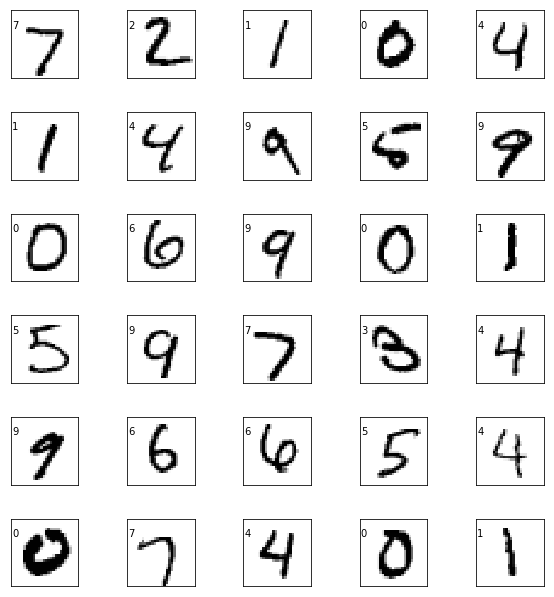

---------------------------------------------------


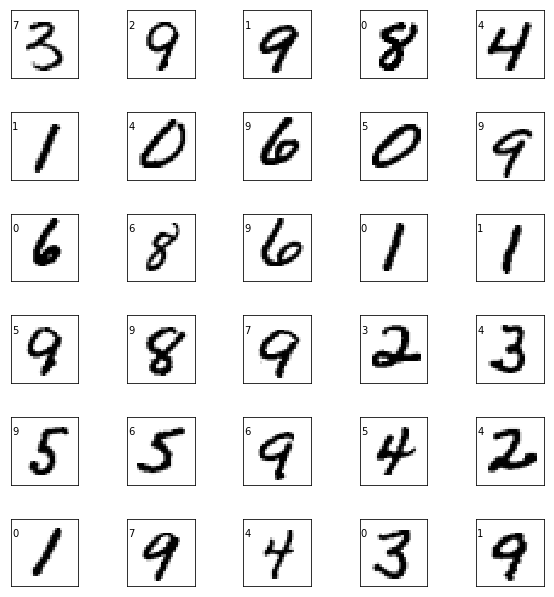

In [59]:
#Test Processing:
with tf.Session(config = config) as sess:
    if os.path.exists('tmp/checkpoint'):        
        saver2.restore(sess, 'tmp/model.ckpt')
        total_batch  = int(len(test_images)/batch_size)
        msg = "Test batch={:d}, lose={:.4f}"
        for b in tqdm(range(total_batch)):
            batch = test_images[b*batch_size:(b+1)*batch_size]
            imgs = batch.reshape((-1,28,28,1))
            sess.run([conv_final,loss], feed_dict={input_x:batch})
            print(msg.format(b,batch_cost))

    else :
        print("Please run training part first")
    fig1 = plt.figure(figsize=(8,8))
    fig1.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(test_images[i],[28,28])
        ax=fig1.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()
    print("---------------------------------------------------")
    fig = plt.figure(figsize=(8,8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.5, wspace=0.05)
    for i in range(30):
        image = np.reshape(imgs[i],[28,28])
        ax=fig.add_subplot(6,5,i+1,xticks=[],yticks=[]) 
        ax.imshow(image,cmap=plt.cm.binary,interpolation='nearest') 
        ax.text(0,7,str(test_labels[i]))
    plt.show()